In [4]:
import os
import csv
import awdb
import json
import re

from tqdm import tqdm
Num_query_all=0         #查询总数
Num_query_success=0     #查询成功总数，不只有a aaaa
Num_query_fail=0        #查询失败总数

Num_query_a_all=0       #查询a记录总数
Num_query_a_success=0   #查询a记录成功数
Num_query_a_fail=0      #查询a记录失败数
Num_query_aaaa_all=0    #查询aaaa总数
Num_query_aaaa_success=0#查询aaaa成功数
Num_query_aaaa_fail=0   #查询aaaa失败数

List_newgTLDs=[]
Num_newgTLDs=0

Dic_state={}
Dic_record_num_all={}       #该种类的记录对应的查询数
Dic_record_num_success={}   #该种类的记录对应的查询成功数

Dic_domain_num_a_all={}     #该域名a查询总数
Dic_domain_num_a_success={} #该域名a查询成功数
Dic_domain_num_a_fail={}    #该域名a查询失败数
Dic_domain_num_aaaa_all={}  #该域名aaaa查询总数
Dic_domain_num_aaaa_success={}#该域名aaaa查询成功数
Dic_domain_num_aaaa_fail={} #该域名aaaa查询失败数

Dic_resolver_num_all={}     #该解析器查询总数
Dic_resolver_num_success={} #该解析器查询成功数
Dic_resolver_num_fail={}    #该解析器查询失败数
Dic_resolver_num_a_all={}   #该解析器查询a记录总数
Dic_resolver_num_a_success={}#该解析器查询a记录成功数
Dic_resolver_num_a_fail={}  #该解析器查询a记录失败数
Dic_resolver_num_aaaa_all={}#该解析器查询aaaa记录总数
Dic_resolver_num_aaaa_success={}#该解析器查询aaaa记录成功数
Dic_resolver_num_aaaa_fail={}#该解析器查询aaaa记录的失败数

Dic_resolver_asnum={}       #该解析器对应的as号
Dic_asnum_asname={}         #该as号对应的as名

Dic_resolver_public_num_all={}#某公共解析器查询总数
Dic_resolver_public_num_success={}
Dic_resolver_public_num_a_all={}
Dic_resolver_public_num_a_success={}
Dic_resolver_public_num_aaaa_all={}
Dic_resolver_public_num_aaaa_success={}

def _init_():
    #读asnum2asname
    global Dic_asnum_asname
    fin=open('./other_data/asnum2asname.txt')
    i=0
    for line in fin:
        list_tp=line.split(None,1)
        Dic_asnum_asname[list_tp[0]]=list_tp[1].strip()
    fin.close()

    #读 new gTLDs
    global List_newgTLDs
    # global Num_newgTLDs
    fin=open('./other_data/new_gtlds_1686227471.csv')
    i=0
    for line in fin:
        tp=line.split(',',1)
        List_newgTLDs.append(tp[0].strip())
    fin.close()

def str2json1(str_0):
    #[{DNS_RR_NAME=smartont.net, DNS_RR_TYPE=6, DNS_RR_CLASS=1, DNS_RR_TTL=372, DNS_RR_LENGTH=52, DNS_RR_MNME=dns15.hichina.com, DNS_RR_RNAME=hostmaster.hichina.com, DNS_RR_SERIAL=2022052002, DNS_RR_REFRESH=3600, DNS_RR_RETRY=1200, DNS_RR_EXPIRE=86400, DNS_RR_MINIUM=600, DNS_RR_CONTENT=dns15.hichina.com,hostmaster.hichina.com,2022052002,3600,1200,86400,600}]
    str_1=str_0.replace(', ','\",\"')#  ,换成 ","
    str_2=str_1.replace('=','\":\"')# =换成":"
    str_3=str_2.replace('}\",\"{','\"},{\"')#}", "{换成"},{"
    str_4=str_3.replace('[{','[{\"')
    str_5=str_4.replace('}]','\"}]')
    return '{\"rr\":'+str_5+'}'
def str2json2(str0):
    #[{DNS_RR_NAME=push.apple.com, DNS_RR_TYPE=16, DNS_RR_CLASS=1, DNS_RR_TTL=2324, DNS_RR_LENGTH=9, DNS_RR_TXT=count=50china.com, DNS_RR_SIZE=8, DNS_RR_CONTENT=count=50china.com,8}]
    str1="{\"rr\":"
    i=-1
    flag_1=1#是否是逗号后的第一个等号
    for c in str0:
        i=i+1
        if i==0:
            str1+=c
        elif c=='{':
            str1+=(c+"\"")
        elif c=='=':
            if flag_1==1:#是逗号后的第一个等号
                str1+="\":\""#重要！！！！！
                flag_1=0
            else:
                str1+=c
        elif c==',':
            if str0[i+1]==' ':
                if str0[i-1]!='}':
                    str1+="\", \""
                else:
                    str1+=', '
                flag_1=1
            else:
                str1+=c
        elif c==' ':
            continue
        elif c=='}':
            str1+=("\""+c)
        elif i==len(str0)-1:
            str1+=c
        else:
            str1+=c
    str1+='}'
    return str1

def judge_recursive(Rdic_rr,Rname,Qname):
    if Rname==Qname:
        return 1
    else:
        tp=0
        for Ritem in Rdic_rr:
            if int(Ritem['DNS_RR_TYPE'])==5 and Ritem['DNS_RR_CNAME']==Rname:
                tp=judge_recursive(Rdic_rr,Ritem['DNS_RR_NAME'],Qname)
                if tp==1:
                    break
        return tp

def judge_success(Rdic_rr,Qname,Qtype):
    #复杂的判别方法是正着找，我们反着找！
    success=0
    if Qtype!=1 and Qtype!=28:#不可能出现递归
        for Ritem in Rdic_rr:#直接找
            if Ritem['DNS_RR_NAME']==Qname and int(Ritem['DNS_RR_TYPE'])==Qtype:
                success=1
    else: #是1或28
        for Ritem in Rdic_rr:#对于所有的答案
            if int(Ritem['DNS_RR_TYPE'])==Qtype:
                if judge_recursive(Rdic_rr,Ritem['DNS_RR_NAME'],Qname)==1:
                    success=1
                    break
            if success==1:
                break
    return success

def ip2asnum(str_ip):
    reader=awdb.open_database(r'./other_data/IP_city_single_BD09_WGS84_ipv6.awdb')
    (record,prefix_len)=reader.get_with_prefix_len(str_ip)
    ans=record.get('asnumber').decode('utf8')
    if ans!='':
        return ans
    else:
        return 'null'

def public_resolver():
    global Dic_resolver_num_all
    global Dic_resolver_num_success
    global Dic_resolver_num_a_all
    global Dic_resolver_num_a_success
    global Dic_resolver_num_aaaa_all
    global Dic_resolver_num_aaaa_success

    #读public_resolver list
    fin=open('./other_data/public_resolver_ip.txt')
    fout=open('./result_data_v6/3_resolver_public.csv','w')
    csv_out=csv.writer(fout)
    csv_out.writerow(['public_resolver','num_all','num_success','rate_success',\
                    'num_a_all','num_a_success','rate_a_success',\
                    'num_aaaa_all','num_aaaa_success','rate_aaaa_success'])
    for line in fin:#对于每个公共解析器
        [public_resolver,ips]=line.split(',',1)
        ips_list=ips.strip().split(',')#是个list
        public_resolver_num_all=0
        public_resolver_num_success=0
        public_resolver_num_a_all=0
        public_resolver_num_a_success=0
        public_resolver_num_aaaa_all=0
        public_resolver_num_aaaa_success=0
        for ip in ips_list:
            if ip in Dic_resolver_num_all:
                public_resolver_num_all+=Dic_resolver_num_all[ip]
            if ip in Dic_resolver_num_success:
                public_resolver_num_success+=Dic_resolver_num_success[ip]
            if ip in Dic_resolver_num_a_all:
                public_resolver_num_a_all+=Dic_resolver_num_a_all[ip]
            if ip in Dic_resolver_num_a_success:
                public_resolver_num_a_success+=Dic_resolver_num_a_success[ip]
            if ip in Dic_resolver_num_aaaa_all:
                public_resolver_num_aaaa_all+=Dic_resolver_num_aaaa_all[ip]
            if ip in Dic_resolver_num_aaaa_success:
                public_resolver_num_aaaa_success+=Dic_resolver_num_aaaa_success[ip]
        if public_resolver_num_all!=0:
            rate_success=str(format(public_resolver_num_success/public_resolver_num_all*100,'.2f'))+'%'
        else:
            rate_success='null'
        if public_resolver_num_a_all!=0:
            rate_a_success=str(format(public_resolver_num_a_success/public_resolver_num_a_all*100,'.2f'))+'%'
        else:
            rate_a_success='null'
        if public_resolver_num_aaaa_all!=0:
            rate_aaaa_success=str(format(public_resolver_num_aaaa_success/public_resolver_num_aaaa_all*100,'.2f'))+'%'
        else:
            rate_aaaa_success='null'
        csv_out.writerow([public_resolver,public_resolver_num_all,public_resolver_num_success,rate_success,\
                        public_resolver_num_a_all,public_resolver_num_a_success,rate_a_success,\
                        public_resolver_num_aaaa_all,public_resolver_num_aaaa_success,rate_aaaa_success])
    fin.close()
    fout.close()

def public_resolver_domains():#挑出不同的解析器各自
    pass

    
def output():#处理结果并输出
    global Dic_record_num_all
    global Dic_record_num_success

    global Num_query_all
    global Num_query_success
    global Num_query_fail
    global Num_query_a_all
    global Num_query_a_success
    global Num_query_a_fail
    global Num_query_aaaa_all
    global Num_query_aaaa_success
    global Num_query_aaaa_fail

    global Dic_domain_num_a_all
    global Dic_domain_num_a_success
    global Dic_domain_num_a_fail
    global Dic_domain_num_aaaa_all
    global Dic_domain_num_aaaa_success
    global Dic_domain_num_aaaa_fail

    dir_out='./result_data_v6'
    file_name_type='1_type.csv'#存放不同类型查询数量、成功数量、失败数量、成功率
    file_name_domain_a='2_domain_a.csv'#存放域名与a记录相关
    file_name_domain_aaaa='2_domain_aaaa.csv'#存放域名与aaaa记录相关
    file_out_path_type=os.path.join(dir_out,file_name_type)
    file_out_path_domain_a=os.path.join(dir_out,file_name_domain_a)
    file_out_path_domain_aaaa=os.path.join(dir_out,file_name_domain_aaaa)

    #不同记录类型输出
    Record_num_all_sorted=dict(sorted(Dic_record_num_all.items(),key=lambda x:x[1],reverse=True))
    file_out_type=open(file_out_path_type,'w')
    csv_out=csv.writer(file_out_type)
    csv_out.writerow(['type','num_all','rate_all','num_success','rate_success'])
    for key,val in Record_num_all_sorted.items():
        csv_out.writerow([key,val,str(format(val/Num_query_all*100,'.2f'))+'%',\
                Dic_record_num_success[key],str(format(Dic_record_num_success[key]/val*100,'.2f'))+'%'])

    #不同域名a记录按失败次数高低输出
    for key in Dic_domain_num_a_all:#a记录
        Dic_domain_num_a_fail[key]=Dic_domain_num_a_all[key]-Dic_domain_num_a_success[key]
    Dic_domain_num_a_fail_sorted=dict(sorted(Dic_domain_num_a_fail.items(),key=lambda x:x[1],reverse=True))
    file_out_domain_a=open(file_out_path_domain_a,'w')
    csv_out=csv.writer(file_out_domain_a)
    #domain域名，num_a_fail是这个域名a记录失败次数，rate_all是这个域名失败次数占所有a失败的次数
    #num_a_all是这个域名所有a记录查询的数量，num_a_success是这个域名所有a记录查询的成功数，rate_a_success是这个域名查询的成功率
    csv_out.writerow(['domain','num_a_fail','rate_all','num_a_all','num_a_success','rate_a_fail'])
    for key,val in Dic_domain_num_a_fail_sorted.items():
        csv_out.writerow([key,val,str(format(val/Num_query_a_fail*100,'.2f'))+'%',\
                        Dic_domain_num_a_all[key],Dic_domain_num_a_success[key],\
                        str(format(val/Dic_domain_num_a_all[key]*100,'.2f'))+'%'])

    #不同域名aaaa记录按失败次数高低输出
    for key in Dic_domain_num_aaaa_all:#aaaa记录
        Dic_domain_num_aaaa_fail[key]=Dic_domain_num_aaaa_all[key]-Dic_domain_num_aaaa_success[key]
    Dic_domain_num_aaaa_fail_sorted=dict(sorted(Dic_domain_num_aaaa_fail.items(),key=lambda x:x[1],reverse=True))
    file_out_domain_aaaa=open(file_out_path_domain_aaaa,'w')
    csv_out=csv.writer(file_out_domain_aaaa)
    #domain域名，num_aaaa_fail是这个域名a记录失败次数，rate_all是这个域名失败次数占所有a失败的次数
    #num_aaaa_all是这个域名所有a记录查询的数量，num_aaaa_success是这个域名所有a记录查询的成功数，rate_aaaa_success是这个域名查询的成功率
    csv_out.writerow(['domain','num_aaaa_fail','rate_all','num_aaaa_all','num_aaaa_success','rate_aaaa_fail'])
    for key,val in Dic_domain_num_aaaa_fail_sorted.items():
        csv_out.writerow([key,val,str(format(val/Num_query_aaaa_fail*100,'.2f'))+'%',\
                        Dic_domain_num_aaaa_all[key],Dic_domain_num_aaaa_success[key],\
                        str(format(val/Dic_domain_num_aaaa_all[key]*100,'.2f'))+'%'])
    
    #单独写个去低频的
    #不同域名a记录按失败次数高低输出
    Num_query_a_fail_frequent=0
    for key in Dic_domain_num_a_all:
        if Dic_domain_num_a_all[key]>=100:
            Num_query_a_fail_frequent+=Dic_domain_num_a_fail[key]
    for key in Dic_domain_num_a_all:#a记录
        Dic_domain_num_a_fail[key]=Dic_domain_num_a_all[key]-Dic_domain_num_a_success[key]
    Dic_domain_num_a_fail_sorted=dict(sorted(Dic_domain_num_a_fail.items(),key=lambda x:x[1],reverse=True))
    file_out_domain_a=open('./result_data_v6/2_domain_a_frequent.csv','w')
    csv_out=csv.writer(file_out_domain_a)
    #domain域名，num_a_fail是这个域名a记录失败次数，rate_all是这个域名失败次数占所有a失败的次数
    #num_a_all是这个域名所有a记录查询的数量，num_a_success是这个域名所有a记录查询的成功数，rate_a_success是这个域名查询的成功率
    csv_out.writerow(['domain','num_a_fail','rate_all','num_a_all','num_a_success','rate_a_fail'])
    for key,val in Dic_domain_num_a_fail_sorted.items():
        if Dic_domain_num_a_all[key]>=100:
            #这里做了个非常辣鸡的改动!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            if Num_query_a_fail_frequent!=0:
                csv_out.writerow([key,val,str(format(val/Num_query_a_fail_frequent*100,'.2f'))+'%',\
                                Dic_domain_num_a_all[key],Dic_domain_num_a_success[key],\
                                str(format(val/Dic_domain_num_a_all[key]*100,'.2f'))+'%'])
            else:
                csv_out.writerow([key,val,'NaN',\
                                Dic_domain_num_a_all[key],Dic_domain_num_a_success[key],\
                                str(format(val/Dic_domain_num_a_all[key]*100,'.2f'))+'%'])
    #不同域名aaaa记录按失败次数高低输出
    Num_query_aaaa_fail_frequent=0
    for key in Dic_domain_num_aaaa_all:
        if Dic_domain_num_aaaa_all[key]>=100:
            Num_query_aaaa_fail_frequent+=Dic_domain_num_aaaa_fail[key]
    for key in Dic_domain_num_aaaa_all:#aaaa记录
        Dic_domain_num_aaaa_fail[key]=Dic_domain_num_aaaa_all[key]-Dic_domain_num_aaaa_success[key]
    Dic_domain_num_aaaa_fail_sorted=dict(sorted(Dic_domain_num_aaaa_fail.items(),key=lambda x:x[1],reverse=True))
    file_out_domain_aaaa=open('./result_data_v6/2_domain_aaaa_frequent.csv','w')
    csv_out=csv.writer(file_out_domain_aaaa)
    #domain域名，num_aaaa_fail是这个域名a记录失败次数，rate_all是这个域名失败次数占所有a失败的次数
    #num_aaaa_all是这个域名所有a记录查询的数量，num_aaaa_success是这个域名所有a记录查询的成功数，rate_aaaa_success是这个域名查询的成功率
    csv_out.writerow(['domain','num_aaaa_fail','rate_all','num_aaaa_all','num_aaaa_success','rate_aaaa_fail'])
    for key,val in Dic_domain_num_aaaa_fail_sorted.items():
        if Dic_domain_num_aaaa_all[key]>=100:
            csv_out.writerow([key,val,str(format(val/Num_query_aaaa_fail_frequent*100,'.2f'))+'%',\
                            Dic_domain_num_aaaa_all[key],Dic_domain_num_aaaa_success[key],\
                            str(format(val/Dic_domain_num_aaaa_all[key]*100,'.2f'))+'%'])
def output2():
    global Dic_record_num_all
    global Dic_record_num_success

    global Num_query_all
    global Num_query_success
    global Num_query_fail
    global Num_query_a_all
    global Num_query_a_success
    global Num_query_a_fail
    global Num_query_aaaa_all
    global Num_query_aaaa_success
    global Num_query_aaaa_fail

    global Dic_resolver_num_all
    global Dic_resolver_num_success
    global Dic_resolver_num_fail
    global Dic_resolver_num_a_all
    global Dic_resolver_num_a_success
    global Dic_resolver_num_a_fail
    global Dic_resolver_num_aaaa_all
    global Dic_resolver_num_aaaa_success
    global Dic_resolver_num_aaaa_fail

    dir_out='./result_data_v6'
    file_name_resolver_all='3_resolver_all.csv'
    file_name_resolver_a='3_resolver_a.csv'
    file_name_resolver_aaaa='3_resolver_aaaa.csv'

    file_out_path_resolver_all=os.path.join(dir_out,file_name_resolver_all)
    file_out_path_resolver_a=os.path.join(dir_out,file_name_resolver_a)
    file_out_path_resolver_aaaa=os.path.join(dir_out,file_name_resolver_aaaa)

    #resolver所有查询输出
    Dic_resolver_num_all_sorted=dict(sorted(Dic_resolver_num_all.items(),key=lambda x:x[1],reverse=True))
    file_out_resolver_all=open(file_out_path_resolver_all,'w')
    csv_out=csv.writer(file_out_resolver_all)
    csv_out.writerow(['resolver_ip','num_all','rate_all','num_success','rate_success','asnum','asname','country'])
    for key,val in Dic_resolver_num_all_sorted.items():
        asnum=Dic_resolver_asnum[key]
        asname=''
        country=''
        if asnum=='null':
            asname='null'
            country='null'
        else:
            [asname,country]=Dic_asnum_asname['AS'+str(Dic_resolver_asnum[key])].rsplit(', ',1)
        csv_out.writerow([key,val,str(format(val/Num_query_all*100,'.2f'))+'%',\
                    Dic_resolver_num_success[key],\
                    str(format(Dic_resolver_num_success[key]/val*100,'.2f'))+'%',\
                    asnum,asname,country])
        
    #resolver的a记录查询输出
    Dic_resolver_num_a_all_sorted=dict(sorted(Dic_resolver_num_a_all.items(),key=lambda x:x[1],reverse=True))
    file_out_resolver_a=open(file_out_path_resolver_a,'w')
    csv_out=csv.writer(file_out_resolver_a)
    csv_out.writerow(['resolver_ip','num_a_all','rate_a_all','num_a_success','rate_a_success','asnum','asname','country'])
    for key,val in Dic_resolver_num_a_all_sorted.items():
        asnum=Dic_resolver_asnum[key]
        asname=''
        country=''
        if asnum=='null':
            asname='null'
            country='null'
        else:
            [asname,country]=Dic_asnum_asname['AS'+str(Dic_resolver_asnum[key])].rsplit(', ',1)
        csv_out.writerow([key,val,str(format(val/Num_query_a_all*100,'.2f'))+'%',\
                    Dic_resolver_num_a_success[key],\
                    str(format(Dic_resolver_num_a_success[key]/val*100,'.2f'))+'%',\
                    asnum,asname,country])
    #resolver的aaaa记录查询输出
    Dic_resolver_num_aaaa_all_sorted=dict(sorted(Dic_resolver_num_aaaa_all.items(),key=lambda x:x[1],reverse=True))
    file_out_resolver_aaaa=open(file_out_path_resolver_aaaa,'w')
    csv_out=csv.writer(file_out_resolver_aaaa)
    csv_out.writerow(['resolver_ip','num_aaaa_all','rate_aaaa_all','num_aaaa_success','rate_aaaa_success','asnum','asname','country'])
    for key,val in Dic_resolver_num_aaaa_all_sorted.items():
        asnum=Dic_resolver_asnum[key]
        asname=''
        country=''
        if asnum=='null':
            asname='null'
            country='null'
        else:
            [asname,country]=Dic_asnum_asname['AS'+str(Dic_resolver_asnum[key])].rsplit(', ',1)
        csv_out.writerow([key,val,str(format(val/Num_query_aaaa_all*100,'.2f'))+'%',\
                    Dic_resolver_num_aaaa_success[key],\
                    str(format(Dic_resolver_num_aaaa_success[key]/val*100,'.2f'))+'%',\
                    asnum,asname,country])
    #搞一个求公共DNS厂商的
    public_resolver()

def process():
    global List_newgTLDs
    global Num_newgTLDs

    global Dic_state
    global Dic_record_num_all
    global Dic_record_num_success

    global Num_query_all
    global Num_query_success
    global Num_query_fail
    global Num_query_a_all
    global Num_query_a_success
    global Num_query_a_fail
    global Num_query_aaaa_all
    global Num_query_aaaa_success
    global Num_query_aaaa_fail

    global Dic_domain_num_a_all
    global Dic_domain_num_a_success
    global Dic_domain_num_a_fail
    global Dic_domain_num_aaaa_all
    global Dic_domain_num_aaaa_success
    global Dic_domain_num_aaaa_fail

    global Dic_resolver_num_all
    global Dic_resolver_num_success
    global Dic_resolver_num_fail
    global Dic_resolver_num_a_all
    global Dic_resolver_num_a_success
    global Dic_resolver_num_a_fail
    global Dic_resolver_num_aaaa_all
    global Dic_resolver_num_aaaa_success
    global Dic_resolver_num_aaaa_fail

    dir_in='./source_data_v6'
    file_names=os.listdir(dir_in)
    for file_name in tqdm(file_names):#对于每个源文件
        if file_name=='.DS_Store':
            continue
        #输入文件的路径
        file_in_path=os.path.join(dir_in,file_name)
        #输入的文件对象
        file_in=open(file_in_path,'r',encoding='utf-8-sig')
        csv_in=csv.reader(file_in)
        i=0
        next(csv_in)
        for line in csv_in:#对于每一行数据
            #对于DNS响应才做处理
            # i+=1
            # if i>100000:
            #     break
            if line[45] in Dic_state:
                Dic_state[line[45]]+=1
            else:
                Dic_state[line[45]]=0
            if line[45]!='0':
                continue
            QorR=int(line[39]) #0是query 1是response
            if QorR==1:#是R 即响应
                Qname=line[48]
                Qtype=int(line[46])#该响应的查询种类 （数字类型
                if Qname in List_newgTLDs:
                    Num_newgTLDs+=1
                #但凡有查询就记录下来
                Num_query_all+=1
                #对不同查询类型的记录
                if Qtype in Dic_record_num_all:
                    Dic_record_num_all[Qtype]+=1
                else:
                    Dic_record_num_all[Qtype]=1
                    #这里注意！！！success同时统计
                    Dic_record_num_success[Qtype]=0
                #对不同查询域名的记录
                if Qtype==1:
                    Num_query_a_all+=1
                    if Qname in Dic_domain_num_a_all:
                        Dic_domain_num_a_all[Qname]+=1
                    else:
                        Dic_domain_num_a_all[Qname]=1
                        Dic_domain_num_a_success[Qname]=0
                elif Qtype==28:
                    Num_query_aaaa_all+=1
                    if Qname in Dic_domain_num_aaaa_all:
                        Dic_domain_num_aaaa_all[Qname]+=1
                    else:
                        Dic_domain_num_aaaa_all[Qname]=1
                        Dic_domain_num_aaaa_success[Qname]=0
                #对不同解析器的记录
                resolver=line[16]#用ipv6标识
                if resolver in Dic_resolver_num_all:
                    Dic_resolver_num_all[resolver]+=1
                else:
                    Dic_resolver_num_all[resolver]=1
                    Dic_resolver_num_success[resolver]=0
                    #ip2asnum
                    Dic_resolver_asnum[resolver]=ip2asnum(resolver)
                    # print('test: '+Dic_resolver_asnum[resolver])
                    ##########################################################问qq要一下
                    # Dic_resolver_asnum[resolver]=1

                if Qtype==1:
                    if resolver in Dic_resolver_num_a_all:
                        Dic_resolver_num_a_all[resolver]+=1
                    else:
                        Dic_resolver_num_a_all[resolver]=1
                        Dic_resolver_num_a_success[resolver]=0
                elif Qtype==28:
                    if resolver in Dic_resolver_num_aaaa_all:
                        Dic_resolver_num_aaaa_all[resolver]+=1
                    else:
                        Dic_resolver_num_aaaa_all[resolver]=1
                        Dic_resolver_num_aaaa_success[resolver]=0
                #下面再判断是否成功
                if line[49]=='[]':
                    continue
                Rdic={}
                if re.search("DNS_RR_TXT",line[49])==None:
                    Rdic=json.loads(str2json1(line[49]))
                else:
                    Rdic=json.loads(str2json2(line[49]))
                success=judge_success(Rdic['rr'],Qname,Qtype)
                if success==1:
                    Num_query_success+=1
                    #记录类型
                    Dic_record_num_success[Qtype]+=1
                    #域名 解析器
                    Dic_resolver_num_success[resolver]+=1
                    if Qtype==1:
                        # print('haha a yes '+Qname)
                        Num_query_a_success+=1
                        Dic_domain_num_a_success[Qname]+=1
                        Dic_resolver_num_a_success[resolver]+=1
                    elif Qtype==28:
                        # print('haha aaaa yes')
                        Num_query_aaaa_success+=1
                        Dic_domain_num_aaaa_success[Qname]+=1
                        Dic_resolver_num_aaaa_success[resolver]+=1
                    # if i<100 and Qtype==1:
                    #     print(Qname)
                    #     print(line[49])
                # else:
                #     if i<10000 and Qtype==1:
                #         print(Qname)
                #         print(line[49])
                    # break
        # break
    Num_query_a_fail=Num_query_a_all-Num_query_a_success
    Num_query_aaaa_fail=Num_query_aaaa_all-Num_query_aaaa_success
    print(Dic_state)
    print(Num_newgTLDs)

if __name__=='__main__':
    _init_()
    process()
    output()
    output2()

100%|██████████| 1/1 [00:25<00:00, 25.27s/it]

{'3': 201240, '0': 797647, '2': 788, '5': 149, '1': 170}
4


In [5]:
print(Num_newgTLDs)
# #0_num
# print('item,num')
# print('Num_query_all,'+str(Num_query_all))
# print('Num_query_success,'+str(Num_query_success))
# print('Num_query_fail,'+str(Num_query_all-Num_query_success))

# print('Num_query_a_all,'+str(Num_query_a_all))
# print('Num_query_a_success,'+str(Num_query_a_success))
# print('Num_query_a_fail,'+str(Num_query_a_fail))

# print('Num_query_aaaa_all,'+str(Num_query_aaaa_all))
# print('Num_query_aaaa_success,'+str(Num_query_aaaa_success))
# print('Num_query_aaaa_fail,'+str(Num_query_aaaa_fail))

# #加上计算以上所有的新值再重新跑一下 no

4


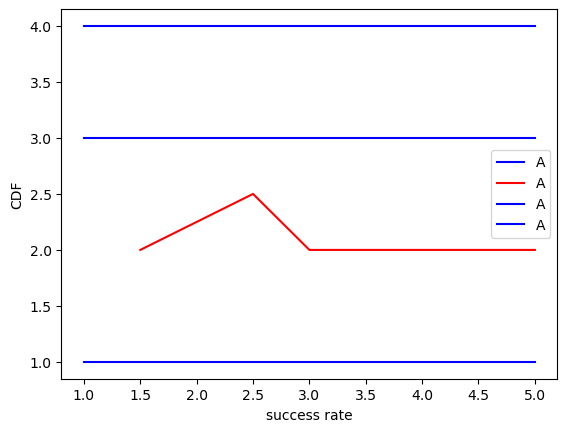

In [18]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4,5],[1,1,1,1,1],'-',color = 'b',label="A")
plt.plot([1.5,2.5,3,4,5],[2,2.5,2,2,2],'-',color = 'r',label="A")
plt.plot([1,2,3,4,5],[3,3,3,3,3],'-',color = 'b',label="A")
plt.plot([1,2,3,4,5],[4,4,4,4,4],'-',color = 'b',label="A")
plt.xlabel("success rate")#横坐标名字
plt.ylabel("CDF")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

21176
21486


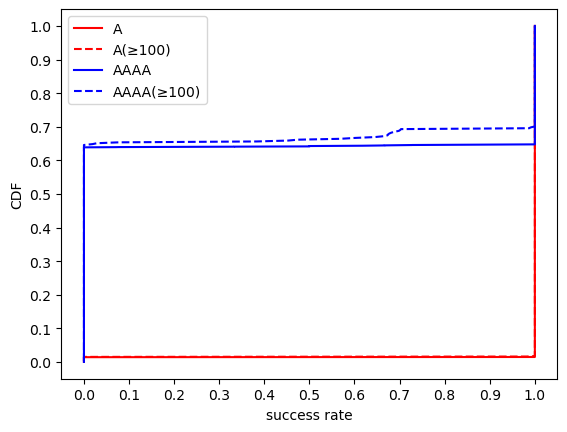

In [16]:
import matplotlib.pyplot as plt
import csv
#横坐标是成功率
x_a=[]
y_a=[]
x_a_frequent=[]
y_a_frequent=[]
x_aaaa=[]
y_aaaa=[]
x_aaaa_frequent=[]
y_aaaa_frequent=[]
standard=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# standard=[]
fin=open('result_data0_v6/paints/2_domain_a.csv')
csv_in=csv.reader(fin)
next(csv_in)
cnt=0
for line in csv_in:
    x_a.append(float(line[4])/float(line[3]))
    if float(line[4])/float(line[3])==1:
        cnt+=1
x_a.sort()
length=len(x_a)
for i in range(1,length+1):
    y_a.append(float(i)/float(length))
fin.close()

fin=open('result_data0_v6/paints/2_domain_a_frequent.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_a_frequent.append(float(line[4])/float(line[3]))
x_a_frequent.sort()
length=len(x_a_frequent)
for i in range(1,length+1):
    y_a_frequent.append(float(i)/float(length))
fin.close()

fin=open('result_data0_v6/paints/2_domain_aaaa.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_aaaa.append(float(line[4])/float(line[3]))
x_aaaa.sort()
length=len(x_aaaa)
for i in range(1,length+1):
    y_aaaa.append(float(i)/float(length))
fin.close()

fin=open('result_data0_v6/paints/2_domain_aaaa_frequent.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_aaaa_frequent.append(float(line[4])/float(line[3]))
x_aaaa_frequent.sort()
length=len(x_aaaa_frequent)
for i in range(1,length+1):
    y_aaaa_frequent.append(float(i)/float(length))
fin.close()

plt.figure()
plt.plot(x_a,y_a,'-',color = 'r',label="A")
plt.plot(x_a_frequent,y_a_frequent,'--',color = 'r',label="A(≥100)")
plt.plot(x_aaaa,y_aaaa,'-',color = 'b',label="AAAA")
plt.plot(x_aaaa_frequent,y_aaaa_frequent,'--',color = 'b',label="AAAA(≥100)")

plt.xticks(standard)
plt.yticks(standard)
plt.xlabel("success rate")#横坐标名字
plt.ylabel("CDF")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

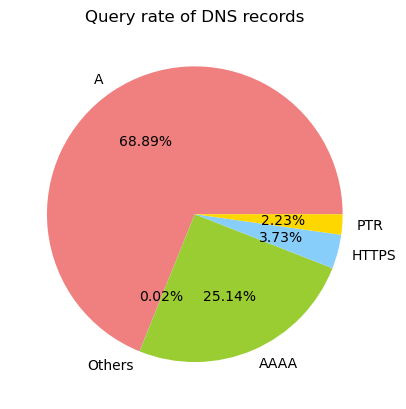

In [2]:
import matplotlib.pyplot as plt
y=[549485,154,200503,29748,17758]
plt.pie(y,
        labels=['A','Others','AAAA','HTTPS','PTR'], # 设置饼图标签
        colors=["lightcoral", "#5d8ca8", "yellowgreen", "lightskyblue", "gold"], # 设置饼图颜色
        autopct='%.2f%%'
       )
plt.title("Query rate of DNS records") # 设置标题
plt.show()

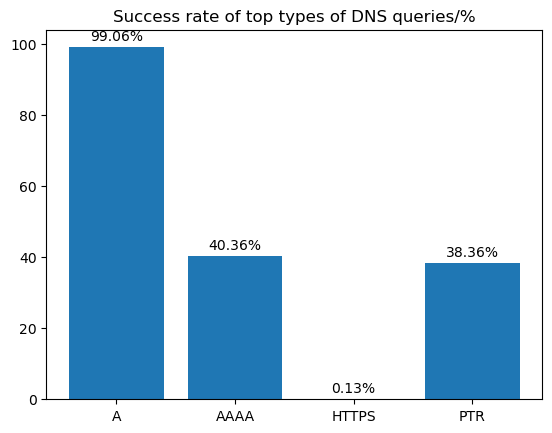

In [3]:
import matplotlib.pyplot as plt

x = ["A", "AAAA", "HTTPS", "PTR"]
y = [99.06,40.36,0.13,38.36]

plt.bar(x,y)
for a,b in zip(x,y):
    plt.text(a,b+1,'%.2f'%b+'%',ha='center',va='bottom')
plt.yticks([0,20,40,60,80,100])
plt.title('Success rate of top types of DNS queries/%')
plt.show()

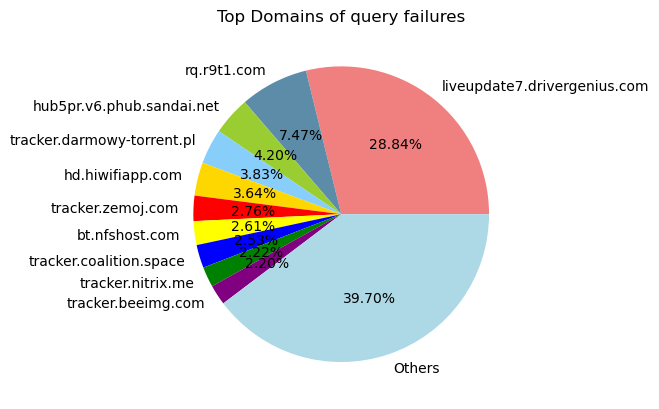

In [4]:
import matplotlib.pyplot as plt
y=[1482,384,216,197,187,142,134,130,114,113,2040]
plt.pie(y,
        labels=['liveupdate7.drivergenius.com','rq.r9t1.com','hub5pr.v6.phub.sandai.net',\
                'tracker.darmowy-torrent.pl','hd.hiwifiapp.com',\
                'tracker.zemoj.com','bt.nfshost.com',\
                'tracker.coalition.space','tracker.nitrix.me',\
                'tracker.beeimg.com','Others'], # 设置饼图标签
        colors=["lightcoral", "#5d8ca8", "yellowgreen", "lightskyblue", "gold",\
                'red','yellow','blue','green','purple','lightblue'], # 设置饼图颜色
        autopct='%.2f%%'
       )

plt.title("Top Domains of query failures") # 设置标题
plt.show()

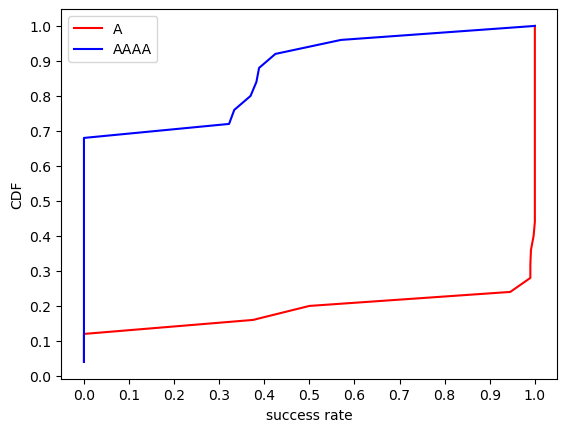

In [19]:
import matplotlib.pyplot as plt
import csv
#横坐标是成功率
y_a=[]
x_a=[]
y_aaaa=[]
x_aaaa=[]

standard=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# standard=[]
fin=open('result_data0_v6/paints/3_resolver_a.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_a.append(float(line[3])/float(line[1]))
x_a.sort()
length=len(x_a)
for i in range(1,length+1):
    y_a.append(float(i)/float(length))
fin.close()

fin=open('result_data0_v6/paints/3_resolver_aaaa.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_aaaa.append(float(line[3])/float(line[1]))
x_aaaa.sort()
length=len(x_a)
for i in range(1,length+1):
    y_aaaa.append(float(i)/float(length))
fin.close()

plt.figure()
plt.plot(x_a,y_a,'-',color = 'r',label="A")
plt.plot(x_aaaa,y_aaaa,'-',color = 'b',label="AAAA")

plt.xticks(standard)
plt.yticks(standard)
plt.xlabel("success rate")#横坐标名字
plt.ylabel("CDF")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

[0, 3, 6, 9, 12, 15, 18]


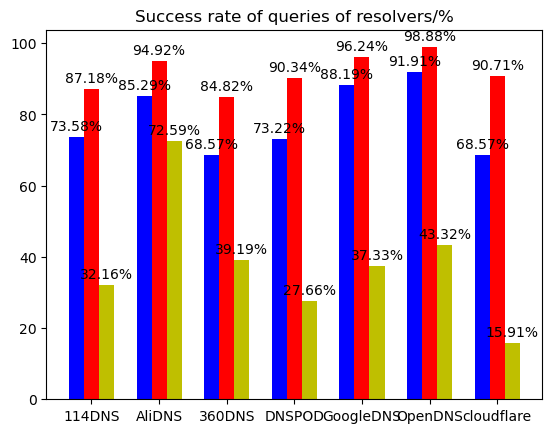

In [62]:
import matplotlib.pyplot as plt

name_list= ["114DNS", "AliDNS", "360DNS", "DNSPOD",'GoogleDNS','OpenDNS','cloudflare']
x=[0,3,6,9,12,15,18]
print(x)
y0 = [73.58,85.29,68.57,73.22,88.19,91.91,68.57]
y1 = [87.18,94.92,84.82,90.34,96.24,98.88,90.71]
y2 = [32.16,72.59,39.19,27.66,37.33,43.32,15.91]
total_width=2
width=total_width/3

plt.bar(x,y0,width=width,label='all',fc='b')
for a,b in zip(x,y0):
    plt.text(a,b+1,'%.2f'%b+'%',ha='center',va='bottom')

for i in range(len(x)):
    x[i]=x[i]+width
plt.bar(x,y1,width=width,label='a',fc='r',tick_label=name_list)
for a,b in zip(x,y1):
    plt.text(a,b+1,'%.2f'%b+'%',ha='center',va='bottom')

for i in range(len(x)):
    x[i]=x[i]+width
plt.bar(x,y2,width=width,label='aaaa',fc='y')
for a,b in zip(x,y2):
    plt.text(a,b+1,'%.2f'%b+'%',ha='center',va='bottom')
plt.yticks([0,20,40,60,80,100])
plt.title('Success rate of queries of resolvers/%')
plt.show()

In [20]:
import csv
import os
import json
from tqdm import tqdm

# def str2json(str_0):
#     #[{DNS_RR_NAME=smartont.net, DNS_RR_TYPE=6, DNS_RR_CLASS=1, DNS_RR_TTL=372, DNS_RR_LENGTH=52, DNS_RR_MNME=dns15.hichina.com, DNS_RR_RNAME=hostmaster.hichina.com, DNS_RR_SERIAL=2022052002, DNS_RR_REFRESH=3600, DNS_RR_RETRY=1200, DNS_RR_EXPIRE=86400, DNS_RR_MINIUM=600, DNS_RR_CONTENT=dns15.hichina.com,hostmaster.hichina.com,2022052002,3600,1200,86400,600}]
#     str_1=str_0.replace(', ','\",\"')#  ,换成 ","
#     str_2=str_1.replace('=','\":\"')# =换成":"
#     str_3=str_2.replace('}\",\"{','\"},{\"')#}", "{换成"},{"
#     str_4=str_3.replace('[{','[{\"')
#     str_5=str_4.replace('}]','\"}]')
#     return '{\"rr\":'+str_5+'}'
def str2json(str0):
    #[{DNS_RR_NAME=push.apple.com, DNS_RR_TYPE=16, DNS_RR_CLASS=1, DNS_RR_TTL=2324, DNS_RR_LENGTH=9, DNS_RR_TXT=count=50china.com, DNS_RR_SIZE=8, DNS_RR_CONTENT=count=50china.com,8}]
    str1="{\"rr\":"
    i=-1
    flag_1=1#是否是逗号后的第一个等号
    for c in str0:
        i=i+1
        if i==0:
            str1+=c
        elif c=='{':
            str1+=(c+"\"")
        elif c=='=':
            if flag_1==1:#是逗号后的第一个等号
                str1+="\":\""#重要！！！！！
                flag_1=0
            else:
                str1+=c
        elif c==',':
            if str0[i+1]==' ':
                if str0[i-1]!='}':
                    str1+="\", \""
                else:
                    str1+=', '
                flag_1=1
            else:
                str1+=c
        elif c==' ':
            continue
        elif c=='}':
            str1+=("\""+c)
        elif i==len(str0)-1:
            str1+=c
        else:
            str1+=c
        
    str1+='}'
    print(str1)
    return str1

if __name__=='__main__':
    tp=str2json('[{DNS_RR_NAME=push.apple.com, DNS_RR_TYPE=16, DNS_RR_CLASS=1, DNS_RR_TTL=2324, DNS_RR_LENGTH=9, DNS_RR_TXT=count=50china.com, DNS_RR_SIZE=8, DNS_RR_CONTENT=count=50china.com,8}]')
    # tp=str2json('[{DNS_RR_NAME=market.m.taobao.com, DNS_RR_TYPE=5, DNS_RR_CLASS=1, DNS_RR_TTL=550, DNS_RR_LENGTH=38, DNS_RR_CNAME=market.m.taobao.com.danuoyi.tbcache.com, DNS_RR_CONTENT=market.m.taobao.com.danuoyi.tbcache.com}, {DNS_RR_NAME=market.m.taobao.com.danuoyi.tbcache.com, DNS_RR_TYPE=1, DNS_RR_CLASS=1, DNS_RR_TTL=44, DNS_RR_LENGTH=4, DNS_RR_A=27.221.120.244, DNS_RR_CONTENT=27.221.120.244}, {DNS_RR_NAME=market.m.taobao.com.danuoyi.tbcache.com, DNS_RR_TYPE=1, DNS_RR_CLASS=1, DNS_RR_TTL=44, DNS_RR_LENGTH=4, DNS_RR_A=27.221.120.236, DNS_RR_CONTENT=27.221.120.236}]')
    Rdic=json.loads(tp)
    print(Rdic)
    # dir_in='./source_data_v6'
    # file_names=os.listdir(dir_in)
    # print('1')
    # for file_name in tqdm(file_names):#对于每个源文件
    #     print(file_name)
    #     if file_name=='.DS_Store':
    #         continue
    #     #输入文件的路径
    #     file_in_path=os.path.join(dir_in,file_name)
    #     #输入的文件对象
    #     file_in=open(file_in_path,'r',encoding='utf-8-sig')
    #     csv_in=csv.reader(file_in)
    #     i=0
    #     next(csv_in)
    #     for line in csv_in:#对于每一行数据
    #         #对于DNS响应才做处理
    #         i+=1
    #         if i>10:
    #             break
    #         if line[45]=='3':#nxdomain
    #             continue
    #         Qname=line[48]
    #         # print(str2json(line[49]))
    #         # tp="{'rr':[{'DNS_RR_NAME':'appdl-drcn.dbankcdn.com', 'DNS_RR_TYPE':5, 'DNS_RR_CLASS':1, 'DNS_RR_TTL':30, 'DNS_RR_LENGTH':36, 'DNS_RR_CNAME':'appdl-drcn.dbankcdn.com.c.cdnhwc1.com', 'DNS_RR_CONTENT':'appdl-drcn.dbankcdn.com.c.cdnhwc1.com'}]}"
    #         # tp="{\"rr\":[{\"name\":\"ntp.ubuntu.com\",\"type\":28,\"class\":1,\"ttl\":30,\"rdlength\":16,\"aaaa\":\"2620:2d:4000:1::40\"}]}"
    #         Rdic=json.loads(str2json(line[49]))
    #         # print(Rdic['rr'])
    #         print(Rdic)
    #     file_in.close()

{"rr":[{"DNS_RR_NAME":"push.apple.com", "DNS_RR_TYPE":"16", "DNS_RR_CLASS":"1", "DNS_RR_TTL":"2324", "DNS_RR_LENGTH":"9", "DNS_RR_TXT":"count=50china.com", "DNS_RR_SIZE":"8", "DNS_RR_CONTENT":"count=50china.com,8"}]}
{'rr': [{'DNS_RR_NAME': 'push.apple.com', 'DNS_RR_TYPE': '16', 'DNS_RR_CLASS': '1', 'DNS_RR_TTL': '2324', 'DNS_RR_LENGTH': '9', 'DNS_RR_TXT': 'count=50china.com', 'DNS_RR_SIZE': '8', 'DNS_RR_CONTENT': 'count=50china.com,8'}]}


In [6]:
filein=open('source_data_v6/DNS_COLLECT_LOG.csv','r')
cnt=0
for line in filein:
    cnt+=1
print(cnt)
filein.close()

1000000
